# Deep Learning w/ Python

## Home Assignment II. by Kristof Rabay - CNN, Reinforcement Learning

---

## C) Newsgroups similarity

In our newsgroups example, the model accuracy on the test set was pretty lackluster. Improve the model by creating a more clever trainset, try out FastText embedding and use more topics (preferably all of them). Create a function which receives a document as text, and prints out the `n` most similar document from the newsgroups dataset.

In [28]:
# function receives doc of text
# print n most similar doc from dataser
# small recommender system

## Solution

Before training I'll do some pre-processing
- removing headers, footers & quotes
- tokenizing
- etc...

I'll do:

1. NN with embedding to classify news articles
2. FastText to find most similar articles

### C.1 Importing necessary libraries and data

In [104]:
import numpy as np
import pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Embedding, Conv1D, MaxPooling1D, Input
from keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras

from sklearn.datasets import fetch_20newsgroups

### C.2 News articles classifier

What are the topics covered in this dataset?

In [10]:
fetch_20newsgroups(subset = 'all').target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Will be using all data to create the recommendation system

In [141]:
data = fetch_20newsgroups(subset = 'all', remove=('headers', 'footers', 'quotes')) # drop headers, etc in the beginning
X = data.data
y = to_categorical(np.asarray(data.target))

In [142]:
labels = {v: k for v, k in enumerate(train.target_names)}
labels = pd.DataFrame(labels.items())
labels = labels.rename(columns={0: 'label', 1: 'news_topic'})
labels

,label,news_topic
0,0,alt.atheism
1,1,comp.graphics
2,2,comp.os.ms-windows.misc
3,3,comp.sys.ibm.pc.hardware
4,4,comp.sys.mac.hardware
5,5,comp.windows.x
6,6,misc.forsale
7,7,rec.autos
8,8,rec.motorcycles
9,9,rec.sport.baseball


In [143]:
X[0], y[0]

("\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n",
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], dtype=float32))

In [144]:
print("\n".join(X[0].split("\n")[:]))



I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!




In [145]:
tokenizer = Tokenizer(num_words = 10000, oov_token = True)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)

In [151]:
dictionary = tokenizer.word_index

In [152]:
X_seq_pad = pad_sequences(X_seq, maxlen = 1000, padding = 'post')

In [161]:
np.random.seed(20202020)
indices = np.arange(X_seq_pad.shape[0])
np.random.shuffle(indices)

X_seq_pad = X_seq_pad[indices]
y = y[indices]

test_indices = int(0.2 * X_seq_pad.shape[0])

X_train = X_seq_pad[:-test_indices]
y_train = y[:-test_indices]
X_test = X_seq_pad[-test_indices:]
y_test = y[-test_indices:]

In [162]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15077, 1000), (15077, 20), (3769, 1000), (3769, 20))

In [163]:
embed_size = 10
max_length = 1000

input = Input(shape = (max_length, ))
embedding = Embedding(input_dim = len(dictionary) + 1, 
                      output_dim = embed_size, 
                      input_length = max_length)(input)

conv1 = Conv1D(256, 5, activation = 'relu')(embedding) 
pool1 = MaxPooling1D(5)(conv1) 

conv2 = Conv1D(256, 5, activation = 'relu')(pool1) 
pool2 = MaxPooling1D(5)(conv2) 

flatten = Flatten()(pool2)
dense = Dense(128, activation = 'relu')(flatten)

output = Dense(y_train.shape[1], activation='softmax')(dense)

model = Model(inputs = input, 
              outputs = output)

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [164]:
model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 1000)              0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 1000, 10)          1394900   
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 996, 256)          13056     
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 199, 256)          0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 195, 256)          327936    
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 39, 256)           0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 9984)              0  

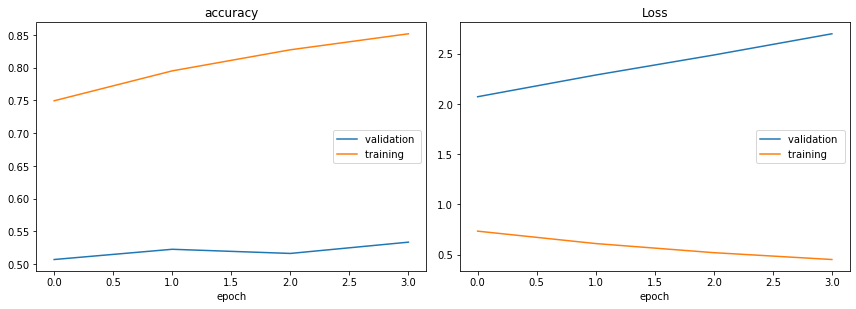

accuracy
	validation       	 (min:    0.079, max:    0.533, cur:    0.533)
	training         	 (min:    0.066, max:    0.903, cur:    0.852)
Loss
	validation       	 (min:    1.733, max:    3.699, cur:    2.698)
	training         	 (min:    0.451, max:    2.968, cur:    0.451)


In [166]:
model.fit(X_train, y_train, epochs = 4, 
          callbacks = [PlotLossesKeras()],
                       #EarlyStopping(monitor = 'val_loss', patience = 5)], 
          validation_data = (X_test, y_test))

In [169]:
model.evaluate(X_train, y_train)

15077/15077 [==============================] - 41s 3ms/step


[0.34557065658171, 0.8942760229110718]

In [170]:
def test_text(string):
    string = [string]
    tokenized = tokenizer.texts_to_sequences(string)
    padded = pad_sequences(tokenized, maxlen = 1000, padding = 'post')
    return(padded)

def prediction_results(text):
    text = test_text(text)
    predictions_list = model.predict(text).tolist()[0]
    predictions_dict = {v: k for v, k in enumerate(predictions_list)}
    predictions = pd.DataFrame(predictions_dict.items())
    predictions = predictions.rename(columns={0: 'label', 1: 'prediction'})
    predictions = predictions.merge(labels, on = ['label'])
    return(predictions.sort_values(by = ['prediction'], ascending = False).head(5))

In [208]:
text = "My mechanic told me I better change the oil and my tires."
prediction_results(text)

,label,prediction,news_topic
7,7,0.717308,rec.autos
8,8,0.251864,rec.motorcycles
12,12,0.024810,sci.electronics
6,6,0.004483,misc.forsale
4,4,0.001411,comp.sys.mac.hardware


### C.3 Leveraging the FastText pre-trained vectors